In [1]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt 
import time
import numpy as np

from collections import Counter
from collections import defaultdict
from wordcloud import WordCloud

## Read Crunchbase Data

In [2]:
df = pd.read_csv('crunchbase_data/crunchbase_blockchain_companies.csv', encoding='utf-8')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 50) # Show full text
df

,Organization Name,Headquarters Location,Headquarters Regions,Estimated Revenue Range,Description,Operating Status,Founded Date,Exit Date,Closed Date,Company Type,Website,Twitter,Facebook,LinkedIn,Contact Email,Phone Number,Number of Articles,Full Description,Hub Tags,Investor Type,Investment Stage,Number of Portfolio Organizations,Number of Investments,Number of Lead Investments,Number of Exits,Number of Exits (IPO),Accelerator Application Deadline,Accelerator Duration (in weeks),Accelerator Program Type,School Type,School Program,Number of Enrollments,School Method,Number of Founders (Alumni),Number of Alumni,Category Groups,Categories,Number of Founders,Founders,Number of Employees,Number of Funding Rounds,Funding Status,Last Funding Date,Last Funding Amount,Last Funding Type,Last Equity Funding Amount,Last Equity Funding Type,Total Equity Funding Amount,Total Funding Amount,Top 5 Investors,Number of Lead Investors,Number of Investors,Acquisition Status,Number of Acquisitions,Transaction Name,Acquired by,Announced Date,Price,Acquisition Type,Acquisition Terms,IPO Status,IPO Date,Delisted Date,Valuation at IPO,Money Raised at IPO,Stock Symbol,Stock Exchange,Number of Events,CB Rank (Organization),CB Rank (Company),CB Rank (School),Trend Score (7 Days),Trend Score (30 Days),Trend Score (90 Days),Monthly Visits,Average Visits (6 months),Monthly Visits Growth,Visit Duration,Visit Duration Growth,Page Views / Visit,Page Views / Visit Growth,Bounce Rate,Bounce Rate Growth,Global Traffic Rank,Monthly Rank Change (#),Monthly Rank Growth,Active Tech Count,Number of Apps,Downloads Last 30 Days,Total Products Active,Most Popular Trademark Class,IT Spend,Most Recent Valuation Range,Date of Most Recent Valuation
0,Kraken,"San Francisco, California, United States","San Francisco Bay Area, West Coast, Western US",$50M to $100M,Kraken is a cryptocurrency exchange that provi...,Active,"Jul 28, 2011",—,—,For Profit,www.kraken.com/,View on Twitter,View on Facebook,View on LinkedIn,support@kraken.com,—,45,Our mission is to accelerate the adoption of c...,Unicorn,—,—,—,—,—,—,—,—,—,—,—,—,—,—,—,—,"Financial Services, Lending and Investments, P...","Asset Management, Blockchain, Cryptocurrency, ...",1,Jesse Powell,501-1000,4,—,"May 21, 2019","$13,500,000",Equity Crowdfunding,"$13,500,000",Equity Crowdfunding,"$118,500,000","$118,500,000","Blockchain Capital, BnkToTheFuture, Digital Cu...",1,6,Made Acquisitions,10,—,—,—,—,—,—,Private,—,—,—,—,—,—,2,68,57,—,-1.1,-2.5,9.0,"2,737,958","3,119,818.28",-3.16%,539,-5.4%,6.66,-4.78%,37.37%,3.08%,"18,642","1,514",8.84%,—,—,—,19,Insurance; financial affairs,"$163,179",—,—
1,Circle,"Boston, Massachusetts, United States","Greater Boston Area, East Coast, New England",$10M to $50M,"Circle is a global internet finance company, b...",Active,2013,—,—,For Profit,www.circle.com/en/,View on Twitter,View on Facebook,View on LinkedIn,info@circle.com,—,186,Circle provides an online platform that enable...,Unicorn,—,—,—,—,—,—,—,—,—,—,—,—,—,—,—,—,"Financial Services, Lending and Investments, P...","Banking, Blockchain, Cryptocurrency, Finance, ...",2,"Jeremy Allaire, Sean Neville",251-500,7,—,"Aug 30, 2018",—,Secondary Market,—,Undisclosed,"$246,000,000","$246,000,000","Blockchain Capital, General Catalyst, Bitmain,...",4,27,Made Acquisitions,3,—,—,—,—,—,—,Private,—,—,—,—,—,—,10,298,275,—,5.9,4.2,2.0,"235,837","229,511.6",-23.43%,338,22.19%,6.65,10.55%,45.13%,-1.41%,"133,921","23,691",21.49%,47,4,"2,364",13,—,—,$1B to $10B,"May 16, 2018"
2,Ripple,"San Francisco, California, United States","San Francisco Bay Area, West Coast, Western US",$10M to $50M,Ripple provides one frictionless experience to...,Active,2012,—,—,For Profit,ripple.com,View on Twitter,View on Facebook,View on LinkedIn,info@ripple.com,—,987,Ripple provides one frictionless experience to...,Unicorn,—,—,9,11,4,1,1,—,—,—,—,—,—,—,—,—,"Financial Services, Internet Services, Payment...","Blockchain, Cryptocurrency, Financial Services...",3,"Arthur Britto, Chris L

### Validate the dataset

In [4]:
# Check that certain startup names exist
names_in_df = [name.lower().strip() for name in df['Organization Name'].tolist()]

names_to_find = ['cryptokitties', 'consensys', 'pixelplex', 'limechain']
for name in names_to_find:
    if name in names_in_df:
        print(name + ' found!')
    else:
        print(name + ' not found...')

# Check startups on the Master List
masterlist_startups = None
with open('masterlist_data/blockchain_startup_names.txt', 'r') as f:
    masterlist_startups = [line.lower().strip() for line in f]
    
found = []
diff_name = []
not_found = []
for name in masterlist_startups:
    #if name in names_in_df:
    found_names = [elem for elem in names_in_df if name in elem.split(' ')]  
    if any(name in x for x in names_in_df):
        if found_names and (len(found_names) > 1 and found_names[0] != name):
            diff_name.append((name, found_names))
        else:
            found.append(name)
    else:
        not_found.append(name)
        
print('\n%d out of %d companies found in master list:' % (len(found), len(masterlist_startups)))
print(found)
print('\n%d may be under a different name:' % len(diff_name))
print(diff_name)
print('\nnot found:')
print(not_found)

cryptokitties found!
consensys found!
pixelplex not found...
limechain found!

64 out of 111 companies found in master list:
['abra', 'aeternity', 'alphapoint', 'airfox', 'ardor', 'ascribe', 'augur', 'backfeed', 'bigchaindb', 'bitfury', 'bitmark', 'bitpay', 'bitse', 'blockmedx', 'blockstream', 'bloq', 'cashaa', 'chain inc.', 'chain of things', 'chainy', 'circle', 'coinbase', 'colu', 'connectjob', 'crowdz', 'cypherium', 'decent', 'dfinity', 'epiphyte', 'filecoin', 'global blockchain', 'herosphere', 'hive blockchain', 'horizon state', 'humaniq', 'hyperledger', 'icobox', 'komodo', 'latoken', 'lisk', 'loci', 'luna', 'minthealth', 'monax', 'odem', 'omisego', 'openbazaar', 'openchain', 'parity technologies', 'peercoin', 'plex', 'propy', 'provenance', 'riot', 'ripio', 'ripple', 'sensay', 'shipchain', 'simplex', 'tenx', 'trusttoken', 'vechain', 'veem', 'xapo']

5 may be under a different name:
[('ark', ['ark ecosystem, scic (ark.io)', 'ark fund']), ('colony', ['honeycomb colony', 'colony']), (

### Keep only the relevant columns

In [5]:
# Filter columns
#df = df[['Organization Name','Categories', 'Description', 'Founded Date', 'Estimated Revenue Range', 'Operating Status', 'Exit Date', 'Closed Date', 'Full Description', 'Category Groups', 'Website']]

# Data Exploration

### See Datapoints based on Founded Year

In [6]:
# Create separate dfs by "Founded Year"
pd.options.mode.chained_assignment = None  # default='warn'
founded_years = []
for i in range(len(df)):
    year = df.loc[i, 'Founded Date'].split(' ')[-1].strip()
    if year != '—':
        assert(year[:2] == '20' or year[:2] == '19' or year[:2] == '18')
        assert(len(year) == 4)
        founded_years.append(year)
    else:
        founded_years.append(None)
        
df['Founded Year'] = founded_years

dfs_by_year = []
unique_years = sorted(list(set(filter(None, founded_years))))

# Only count companies founded after 2008 and before 2020
unique_years = list(filter(lambda year: int(year) >= 2008 and int(year) < 2020, unique_years))

for year in unique_years:
    year_df = df[df['Founded Year'] == year]
    
    dfs_by_year.append(year_df)
    
#df = df.drop(columns=['Founded Year'])
    
print('%d years found in data are >= 2008 and < 2020' % len(dfs_by_year))
print('Number of companies in each year:')
for d in dfs_by_year:
    print('%d ' % len(d), end='')

12 years found in data are >= 2008 and < 2020
Number of companies in each year:
33 56 74 103 110 342 503 449 677 1941 1609 271 

In [7]:
pd.set_option('display.max_colwidth', None) # Show full text
dfs_by_year[0]

,Organization Name,Headquarters Location,Headquarters Regions,Estimated Revenue Range,Description,Operating Status,Founded Date,Exit Date,Closed Date,Company Type,Website,Twitter,Facebook,LinkedIn,Contact Email,Phone Number,Number of Articles,Full Description,Hub Tags,Investor Type,Investment Stage,Number of Portfolio Organizations,Number of Investments,Number of Lead Investments,Number of Exits,Number of Exits (IPO),Accelerator Application Deadline,Accelerator Duration (in weeks),Accelerator Program Type,School Type,School Program,Number of Enrollments,School Method,Number of Founders (Alumni),Number of Alumni,Category Groups,Categories,Number of Founders,Founders,Number of Employees,Number of Funding Rounds,Funding Status,Last Funding Date,Last Funding Amount,Last Funding Type,Last Equity Funding Amount,Last Equity Funding Type,Total Equity Funding Amount,Total Funding Amount,Top 5 Investors,Number of Lead Investors,Number of Investors,Acquisition Status,Number of Acquisitions,Transaction Name,Acquired by,Announced Date,Price,Acquisition Type,Acquisition Terms,IPO Status,IPO Date,Delisted Date,Valuation at IPO,Money Raised at IPO,Stock Symbol,Stock Exchange,Number of Events,CB Rank (Organization),CB Rank (Company),CB Rank (School),Trend Score (7 Days),Trend Score (30 Days),Trend Score (90 Days),Monthly Visits,Average Visits (6 months),Monthly Visits Growth,Visit Duration,Visit Duration Growth,Page Views / Visit,Page Views / Visit Growth,Bounce Rate,Bounce Rate Growth,Global Traffic Rank,Monthly Rank Change (#),Monthly Rank Growth,Active Tech Count,Number of Apps,Downloads Last 30 Days,Total Products Active,Most Popular Trademark Class,IT Spend,Most Recent Valuation Range,Date of Most Recent Valuation,Founded Year
96,CloudCover,"Burnsville, Minnesota, United States","Greater Minneapolis-Saint Paul Area, Great Lakes, Midwestern US",Less than $1M,AI-SOAR cyber security orchestration automation risk platform providing sub-second protection that enables cyber data insurance on-demand.,Active,"Jan 11, 2008",—,—,For Profit,cloudcover.cc,View on Twitter,View on Facebook,View on LinkedIn,contact@cloudcover.net,651-900-1858,—,"CloudCover is a full-spectrum cyber security platform utilizing AI machine learning to deliver real time risk aware protection and data security control. Our platform employs network risk analytics including risk score that enables underwriting cybersecurity data insurance on-demand, incrementally.\n\nCloudCover deploys as an AI-enhanced Security Orchestration Automation Risk Response (SOAR) network solution operating in microsecond speed at over nine-nines (99.9999999%) accuracy.\n\nOur CC/B1 extends onto a customer’s network as real-time sensors and therein utilizing AI/ML is capable of detecting-anticipating known, unseen and previously unknown threats at the network computing edge. The CC/B1 is module-based and may be custom configured into practically any network enterprise, telco and/or edge computing security device.\n\nSince inception, our CyberSafety Platform represents the most advance cybersecurity solution in the market today. CloudCover’s technology portfolio has integrated artificial intelligent systems and methods including blockchain technology that will revolutionize the unique protection that represent our cyber safety platform. We are transforming traditional data security and privacy methods into real time insured cyber safe, compliant ecosystems.",—,—,—,—,—,—,—,—,—,—,—,—,—,—,—,—,—,"Financial Services, Information Technology, Privacy and Security","Blockchain, Cyber Security, Insurance",1,Stephen Cardot,1-10,6,—,"Dec 1, 2019","$190,000",Venture - Series Unknown,"$190,000",Venture - Series Unknown,"$2,125,000","$2,125,000",—,—,—,—,—,—,—,—,—,—,—,Private,—,—,—,—,—,—,—,"25,213","24,419",—,1.3,3.4,5.7,824,160.57,—,21,—,1.17,—,83.22%,—,"10,954,267",—,—,6,—,—,8,Scientific and technological services,—,—,—,2008
134,CloseCross,"London, England, United Kingdom",—,—,CloseCross is the first fully decentra

### Create histograms for different years

In [8]:
# Get all words in a column
def get_column_words(df, column_name, year=None):
    if year:
        df = df[df['Founded Year'] == year]
    words_list = []
    for words in df[column_name].tolist():
        words = list(map(str.strip, words.split(',')))
        words = list(filter(lambda x: x != '—', words))
        words_list.extend(words)
    return words_list

# Get all unique words in a column
def get_column_words_unique(df, column_name, year=None):
    words_list = get_column_words(df, column_name, year=None)
    unique_words_list = sorted(list(set(words_list)))
    return unique_words_list

def get_column_words_with_counts(df, column_name, year=None):
    words_list = get_column_words(df, column_name, year)
    return list_to_dict(words_list)

# Convert list to dictionary where key is the element and value is the count
def list_to_dict(list_item, vocab=None):
    if vocab:
        words_count_dict = dict.fromkeys(vocab,0)
        for word in list_item:
            words_count_dict[word] += 1
        return words_count_dict
    return Counter(list_item)

# Shows word cloud given a list of words (just for fun)
def show_word_cloud(words_list, title=''):
    words_count_dict = list_to_dict(words_list)
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white',
                    min_font_size = 10)
    wordcloud.generate_from_frequencies(words_count_dict)
                    
    plt.figure(figsize = (3, 3), facecolor = None)
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    if title != '':
        plt.title(title)
    plt.show()
    
# Creates histogram of frequency of words given a list of words
def create_histogram(words_list, vocab, title='', savepath='', max_y=None, show=True, log=False):
    words_count_dict = get_hist_data(words_list, vocab)
        
    plt.ioff()
    fig = plt.figure(figsize = (10, 10), facecolor = None);
    if title != '':
        plt.title(title);
    plt.bar(list(words_count_dict.keys()), words_count_dict.values(), color='g');
    plt.xticks(rotation='vertical');
    plt.yscale('linear')
    min_y = 0
    if log:
        plt.yscale('log')
        max_y = np.log(max_y)
        min_y = 1
    if max_y:
        plt.ylim((min_y, max_y));
    plt.tight_layout();
    if savepath != '':
        plt.savefig(savepath);
        plt.close(fig)
        print('histogram saved: %s' % savepath)
    if show:
        plt.show()
        
    
def get_max_word_count(df, column_name, year=None):
    all_words = get_column_words_with_counts(df, column_name, year=year)
    return all_words.most_common(1)[0][1]
    
# Get histogram data as a dict where keys include all words in vocabulary and values are the counts
def get_hist_data(words_list, vocab):
    words_count_dict = list_to_dict(words_list, vocab)
    words_count_dict = dict(sorted(words_count_dict.items(), key=lambda x: x[0]))
    return words_count_dict

In [9]:
# Get Max Y value for plotting
max_y = 0
for year in unique_years:
    max_y = max(max_y, get_max_word_count(df, 'Category Groups', year=year))

# Plot and save histograms
categories_vocab = get_column_words_unique(df, 'Category Groups')
for year in unique_years:
    categories = get_column_words(df, 'Category Groups', year=year)
    create_histogram(categories, categories_vocab, title=year, show=False, max_y=max_y, savepath='images/Category_Groups_%s.png' % year)
    create_histogram(categories, categories_vocab, title=year, show=False, max_y=max_y, log=True, savepath='images/(log)Category_Groups_%s.png' % year)

histogram saved: images/Category_Groups_2008.png
histogram saved: images/(log)Category_Groups_2008.png
histogram saved: images/Category_Groups_2009.png
histogram saved: images/(log)Category_Groups_2009.png
histogram saved: images/Category_Groups_2010.png
histogram saved: images/(log)Category_Groups_2010.png
histogram saved: images/Category_Groups_2011.png
histogram saved: images/(log)Category_Groups_2011.png
histogram saved: images/Category_Groups_2012.png
histogram saved: images/(log)Category_Groups_2012.png
histogram saved: images/Category_Groups_2013.png
histogram saved: images/(log)Category_Groups_2013.png
histogram saved: images/Category_Groups_2014.png
histogram saved: images/(log)Category_Groups_2014.png
histogram saved: images/Category_Groups_2015.png
histogram saved: images/(log)Category_Groups_2015.png
histogram saved: images/Category_Groups_2016.png
histogram saved: images/(log)Category_Groups_2016.png
histogram saved: images/Category_Groups_2017.png
histogram saved: images/

### Create line graphs for different years and category groups

In [10]:
def plot_companies_per_year(dfs_by_year, category_group='', title='', max_y=None, log=False):
    assert(type(category_group) == str)
    x_vals = []
    y_vals = []
    for df in dfs_by_year:
        year = df['Founded Year'].iloc[0]
        
        if category_group != '':
            df = df[df['Category Groups'].str.contains(category_group)]

        x_vals.append(year)
        y_vals.append(len(df))
    
    if max_y:
        plt.ylim((0, max_y))
    plt.yscale('linear')
    if log:
        plt.yscale('log')
    plt.xlabel('Year')
    plt.ylabel('Number of Companies Founded')
    plt.title(title)
    plt.plot(x_vals, y_vals, '-o')
    plt.show()
    
def plot_companies_per_year_per_category(dfs_by_year, category_group=[], title='', log=False):
    for group in category_group:
        x_vals = []
        y_vals = []
        for df in dfs_by_year:
            year = df['Founded Year'].iloc[0]

            df = df[df['Category Groups'].str.contains(group)]

            x_vals.append(year)
            y_vals.append(len(df))

        plt.yscale('linear')
        if log:
            plt.yscale('symlog')
        plt.xlabel('Year')
        plt.ylabel('Number of Companies Founded')
        plt.title(title)
        plt.plot(x_vals, y_vals, '-o', label=group)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

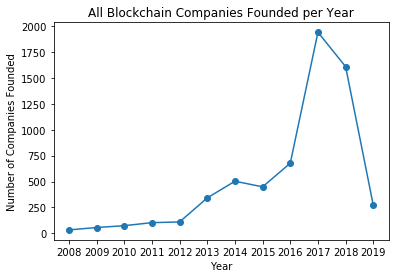

In [11]:
plot_companies_per_year(dfs_by_year, title='All Blockchain Companies Founded per Year', log=False)

In [12]:
# Get top 10 Category Groups with most companies
n = 10
all_categories = get_column_words_with_counts(df, 'Category Groups')
top_categories = all_categories.most_common(n)
top_categories_list = list(zip(*top_categories))[0]

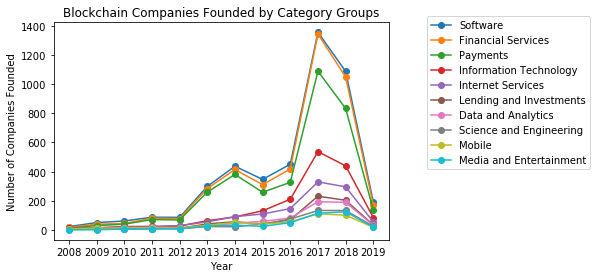

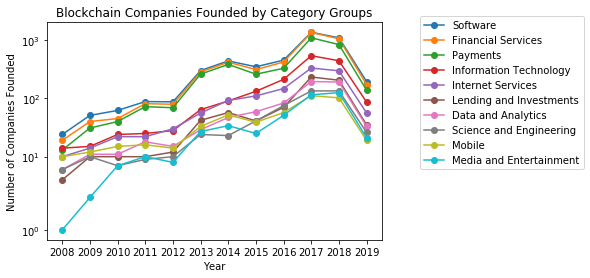

In [13]:
#categories = ['Apps', 'Artificial Intelligence', 'Biotechnology', 'Financial Services']
categories = top_categories_list
plot_companies_per_year_per_category(dfs_by_year, category_group=categories, log=False, title='Blockchain Companies Founded by Category Groups')
plot_companies_per_year_per_category(dfs_by_year, category_group=categories, log=True, title='Blockchain Companies Founded by Category Groups')